# English level


Просмотр фильмов на оригинальном языке - это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.е. студент понимал 50-70 % диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат.

### Задача:

🔸 Разработать ML решение(многоклассовой классификации) для автоматического определения уровня сложности англоязычных фильмов  


### Полученные данные 

1) 2 файла со словами, соответсвующими разным уровням владения американского английского и 2 аналогичных файла для британского английского. 

2) таблица *movies_labels.xlsx* соответствия фильмов и целевого признака - уровня владения языком. 

3) папка *Subtitles_all*, в которой можно найти 4 папки с фильмами по уровням А2 В1 В2 С1 и папку Subtitles, которую можно разложить по уровням с помощью таблицы movies_labels.xlsx


### План работы с проектом

1) **Загрузка библиотек и сбор данных.** На данном этапе проводится читка данных, объединение таблиц, первичный анализ на взвешенность классов

2) **Предобработка данных.** Здесь происходит обработка от лишних символов, приведение слов к общему виду, удаление лишних данных и слов. Также проводится разделение на выборки для дальнейшего обучения и векторизация данных

3) **Обучение моделей.** Проверка различных моделей, поиск оптимальных параметров и лучшей метрики, сравнение полученных результатов

4) **Вывод.** Итоги проделанной работы 

5) **Улучшения.**






## Загрузка библиотек и сбор данных

In [1]:
import os
import pysrt
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import re
from tqdm import tqdm


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
import matplotlib.pyplot as plt
 

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.naive_bayes import (MultinomialNB,
                                GaussianNB)
from sklearn.svm import SVC
from catboost import CatBoostClassifier

STATE = 42

In [2]:
#загрузим файл с размеченными фильмами
pth1 = 'C:/Users/Lerusik/Desktop/Мастерская 2\movies_labels.xlsx'
movies_labels = pd.read_excel(pth1) 

#приведем к нижнему регистру названия столбцов
movies_labels.columns = movies_labels.columns.str.lower()

In [3]:
#загрузим файлы с размеченными фильмами
name_list = []
sub_list = []
level_list = []

subtitles_dir = os.listdir('Subtitles_all')
for i in subtitles_dir:
    path = f'Subtitles_all/{i}'
    path_files = os.listdir(path)
    
    for sub in path_files:
        text = pysrt.open(f'Subtitles_all/{i}/{sub}', encoding='latin-1')        
        name_list.append(sub[:-4])
        level_list.append(i)
        sub_list.append([text.text])

data = pd.DataFrame({'movie': name_list, 'subtitles': sub_list, 'level': level_list})

#объединим таблицы
data = data.merge(movies_labels, on='movie')

In [4]:
# Объявим функцию level_func с одним параметром:
def level_func(rows):
    """
    Функция проверяет совпадение уровней из разных источников и меняет на известное
    
    Параметры:
    rows - выбранные столбцы датафрейма.
    """
    different_level = 0
    level_x = rows['level_x']
    level_y = rows['level_y']
    if level_x != level_y:
        level_x = level_y
        different_level += 1
    
    return level_x
        

In [5]:
#применим функцию
data['level_x'] = data.apply(level_func, axis=1)
#удалим ненужные столбцы
data.drop(columns=['movie', 'id', 'level_y'], axis= 1 , inplace= True )
#переименуем название столбца
data.columns = data.columns.str.replace('level_x', 'level')

<AxesSubplot:xlabel='level', ylabel='count'>

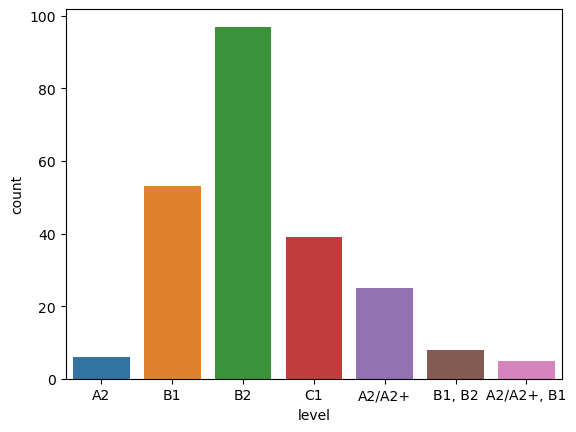

In [6]:
#посмотрим уникальные значения уровней и их распределение
sns.countplot(data=data, x="level")

В случае с двойными метками поставим ограничение: более сложный фильм, чтобы пользователь точно понял контекст фильма.

In [7]:
label_dict = {'A2/A2+': 'A2',
              'A2/A2+, B1': 'B1',
              'B1, B2': 'B2'}
# заменим метки
data['level'] = data['level'].replace(label_dict)

In [8]:
data['level'].value_counts()

B2    105
B1     58
C1     39
A2     31
Name: level, dtype: int64

Видим перекос, но пока ничего не делаем с этим за неимением других данных и малым количеством

## Предобработка данных

### Обработка регулярными выражениями

Очистка от «мусора». В данном случае очистка подразумевает удаление спецсимволов, опечаток, слов с неправильной кодировкой, знаков пунктуации.  

In [9]:
#del_n = r'[\n][a-z]*'               # перенос каретки на пробел
del_tags = r'<[^>]*>'       # html-теги на пробел
del_comments = r'[\[[a-z]+\]]' # комменты в скобках меняем на пробел
del_letters = r'[^\w\s]' # все что не буквы меняем на пробел
del_spaces = r'([ ])\1+' # повторяющиеся пробелы меняем на один пробел
del_dots = r'[\.]+' # многоточие меняем на точку
del_sym = r'[.,"\-?:!;]' # знаки препинания кроме апострофа

In [10]:
#удалим все цифры 
#удалим все n перед словами

In [11]:
def prepare_text(text):
    text = str(text).lower() # текст в нижний регистр
    #text = re.sub(del_n, ' ', text) # перенос каретки 
    text = re.sub(del_tags, ' ', text) # html-теги
    text = re.sub(del_comments, ' ', text) # комменты в скобках
    text = re.sub(del_letters, ' ', text) # все что не буквы
    text = re.sub(del_spaces, ' ', text) # повторяющиеся пробелы
    text = re.sub(del_dots, ' ', text) # многоточие
    text = re.sub(del_sym, ' ', text) # знаки препинания кроме апострофа
    text = re.sub('www', '', text) # кое-где остаётся www, то же меняем на пустую строку
    text = text.lstrip().rstrip().replace("\n","") # обрезка пробелов слева
    text = text.encode('ascii', 'ignore').decode() # удаляем все что не ascii символы
    text = [w for w in text.split() if len(w) >= 3] # удаляем слова короче 3х символов
    text = ' '.join(text)
    return text

In [12]:
#до
data['subtitles']

0      [( bugs chittering )\n( brakes squeak )\n- ( e...
1      [- ( birds chirping )\n- ( bugs chittering )\n...
2      [( thunder rumbling )\nMerle:\nThat's right. Y...
3      [( birds chirping )\n- What?\n- Nothing.\nIt's...
4      [- ( walkie-talkie squawks )\n- Rick: Morgan,\...
                             ...                        
228    [<i>Life\nFoundation Control, this is LF1.</i>...
229    [<i>What am I doing</i>\n<i>with my life?</i>\...
230    [<i>Oh, my God...</i>\n<i>...it's full-on doub...
231    [LUCY: <i>Okay, there are two things that</i>\...
232    [Fear. Treachery Bloodlust.\nThousands of year...
Name: subtitles, Length: 233, dtype: object

In [13]:
#применим функцию очистки
data['subtitles'] = data['subtitles'].apply(prepare_text)
#после
data['subtitles']

0      bugs chittering brakes squeak engine stops tru...
1      birds chirping bugs chittering nboy mom nright...
2      thunder rumbling nmerle nthat right you heard ...
3      birds chirping what nothing nit not nothing ni...
4      walkie talkie squawks rick morgan don know you...
                             ...                        
228    life nfoundation control this lf1 the specimen...
229    what doing with life pale should get out more ...
230    god full double rainbow all nthe way across th...
231    lucy okay there are two things that remember a...
232    fear treachery bloodlust nthousands years ago ...
Name: subtitles, Length: 233, dtype: object

### Стемминг и лемматизация

Стемминг — это процесс нахождения основы слова, а лемматизация — процесс нахождения нормальной формы слова. 

Удаление стоп‑слов. К стоп‑словам в рамках обработки и анализа текстовой информации обычно относят служебные части речи, такие как частицы, союзы, предлоги и междометия, которые часто можно встретить в тексте

In [14]:
#additional_stopwords = ['это',]
stop_words = stopwords.words('english') #+ additional_stopwords

def del_stopwords(text):
    clean_tokens = tuple(
        map( lambda x: x if x not in stop_words else '', word_tokenize(text) )
    )
    
    res_text = ' '.join(clean_tokens)
    return res_text


m = Mystem()

def lemmatize(text):    
    lemmatized_text = ''.join(m.lemmatize(text))
    return lemmatized_text.split('|')

In [15]:
data['subtitles'] = data['subtitles'].apply(del_stopwords)
data['subtitles'] = data['subtitles'].apply(lemmatize)

In [16]:
data['subtitles']

0      [bugs chittering brakes squeak engine stops tr...
1      [birds chirping bugs chittering nboy mom nrigh...
2      [thunder rumbling nmerle nthat right  heard bi...
3      [birds chirping  nothing nit  nothing nit alwa...
4      [walkie talkie squawks rick morgan  know     k...
                             ...                        
228    [life nfoundation control  lf1  specimens  sec...
229    [   life pale  get    eat better posture terri...
230    [god full double rainbow  nthe way across  sky...
231    [lucy okay   two things  remember  childhood  ...
232    [fear treachery bloodlust nthousands years ago...
Name: subtitles, Length: 233, dtype: object

### Разделение на выборки

In [17]:
features = data['subtitles']
target = data['level']

In [18]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25, 
                                                                            random_state=STATE, 
                                                                            shuffle=True)

### Векторизация

In [19]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_train = tfidf_vectorizer.fit_transform(features_train.astype(str)).toarray() 
tfidf_test = tfidf_vectorizer.transform(features_test.astype(str)).toarray() 

In [20]:
count_vectorizer = CountVectorizer()

cv_train = count_vectorizer.fit_transform(features_train.astype(str))
cv_test = count_vectorizer.transform(features_test.astype(str))

## Построение моделей


### CatBoostClassifier

In [ ]:
# для tfidf_vectorizer 
model = CatBoostClassifier()
scores = cross_val_score(model, tfidf_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

Learning rate set to 0.071551
0:	learn: 1.3530881	total: 676ms	remaining: 11m 15s
1:	learn: 1.3320619	total: 1.13s	remaining: 9m 25s
2:	learn: 1.2994139	total: 1.62s	remaining: 8m 58s
3:	learn: 1.2682466	total: 2.09s	remaining: 8m 41s
4:	learn: 1.2410163	total: 2.56s	remaining: 8m 28s
5:	learn: 1.2159496	total: 3.04s	remaining: 8m 24s
6:	learn: 1.2014030	total: 3.52s	remaining: 8m 19s
7:	learn: 1.1849151	total: 3.97s	remaining: 8m 12s
8:	learn: 1.1592545	total: 4.45s	remaining: 8m 9s
9:	learn: 1.1421770	total: 4.89s	remaining: 8m 4s
10:	learn: 1.1152976	total: 5.34s	remaining: 8m
11:	learn: 1.0984360	total: 5.79s	remaining: 7m 56s
12:	learn: 1.0796608	total: 6.22s	remaining: 7m 52s
13:	learn: 1.0688078	total: 6.67s	remaining: 7m 49s
14:	learn: 1.0509902	total: 7.12s	remaining: 7m 47s
15:	learn: 1.0364809	total: 7.56s	remaining: 7m 45s
16:	learn: 1.0163990	total: 8s	remaining: 7m 42s
17:	learn: 1.0086716	total: 8.46s	remaining: 7m 41s
18:	learn: 0.9955849	total: 8.9s	remaining: 7m 39s
1

In [ ]:
# для count_vectorizer
model = CatBoostClassifier()
scores = cross_val_score(model, cv_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

### GaussianNB - байесовский классификатор

In [21]:
# для tfidf_vectorizer 
model = GaussianNB()
scores = cross_val_score(model, tfidf_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.6480500006530299


In [22]:
# для count_vectorizer
model = GaussianNB()
scores = cross_val_score(model, cv_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: nan


C:\Users\Lerusik\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lerusik\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lerusik\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 245, in fit
    return self._partial_fit(
  File "C:\Users\Lerusik\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 402, in _partial_fit
    X, y = self._validate_data(X, y, reset=first_call)
  File "C:\Users\Lerusik\

### MultinomialNB - байесовский классификатор

In [23]:
# для tfidf_vectorizer
model = MultinomialNB()
scores = cross_val_score(model, tfidf_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.3081516914458091


In [24]:
# для count_vectorizer
model = MultinomialNB()
scores = cross_val_score(model, cv_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.6098250680072883


### SVC

In [25]:
# для tfidf_vectorizer
model = SVC(decision_function_shape="ovo")
scores = cross_val_score(model, tfidf_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)


Средняя оценка качества модели: 0.545093905615595


In [26]:
# для count_vectorizer 
model = SVC(decision_function_shape="ovo")
scores = cross_val_score(model, cv_train, target_train, cv=5, scoring='f1_weighted')
final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.4317248155464446


### Тестирование лучшей модели

In [27]:
model = GaussianNB()
model.fit(tfidf_train, target_train)

predictions = model.predict(tfidf_test)
f1 = f1_score(target_test, predictions, average='weighted')

print(f1)

0.5619471551674943


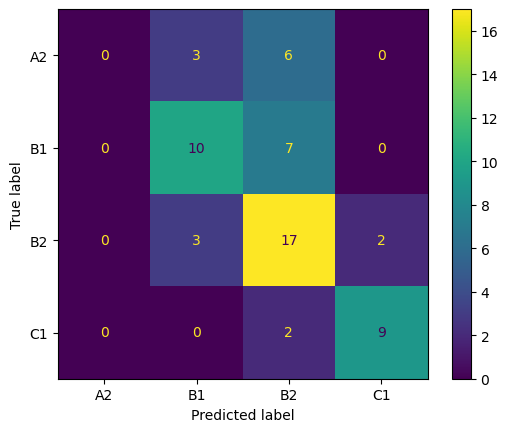

In [28]:
warnings.filterwarnings('ignore') #отключаем предупреждения
plot_confusion_matrix(model, tfidf_test, target_test)  
plt.show()

## Выводы

Данная работа была направлена на анализ субтитров к фильмам для изучения английского языка. Необходима система, помогающая подобрать фильм, соответсвующий нужному уровню владения языком. 

Данные были получены в виде таблиц с размеченными по уровням фильмам, а также субтитрами. Обработка субтитров состояла в применении регулярных выражений для очистки от лишних символов и ненужных слов. Далее применена лемматизация и стэмминг для выявления основных форм слов и удаления дубликатов. Далее применены 2 варианта векторизации - подготовительный этап кодировки данных для дальнейшей загрузки в модели обучения. 

На этапе построения моделей машинного обучения было принято решение использовать следующие модели: CatBoostClassifier, MultinomialNB и GaussianNB - байесовские классификаторы, а также SVC - метод опорных векторов. 

Для измерения качества мультиклассификации была выбрана метрика f1_weighted, поскольку исходные данные не сбалансированы по классам. Также необходимо выбрать модель не только с хорошей метрикой точности, но полнотой, поэтому нужно объединяющая метрика, которой и является f1.

С помощью кросс-валидации были получены метрики на основных данных, лучшей моделью оказалась **GaussianNB**  метрикой *f1_weighted = 0,65*, поэтому далее она тестировалась на тестовых данных и дала результат *f1_weighted = 0,56*

## Улучшения

 1) загрузить данные словарей и вручную посмотреть совпадения с количеством слов
 
 2) посмотреть наиболее частые слова
 
 3) более тщательно обработать регулярками
 
 4) посмотреть улучшенные методы лемматизации и стэмминга, также использовать NLTK, Gensim, SpaCy
 
 5) попробовать векторизацию Word2Vec и Bag Of Words
 
 6) перебрать больше моделей и параметров в каждой модели
 
 7) Расширить датасет с помощью сервисов
 
 8) Добавить больше визуальности в данные

https://subscene.com/  

https://www.opensubtitles.org/ru/search/sublanguageid-eng)

https://languageresearch.cambridge.org/wordlists/text-inspector
 
https://www.cathoven.com/en/cefr-checker/

[www.roadtogrammar.com/textanalysis/](http://www.roadtogrammar.com/textanalysis/)
  
https://textinspector.com/